_This Notebook is to test the Monte Carlo facilities of PyNeb. It is aimed to compare results obtained with keyword 'orig', which are the results using the original data, with the results obtained with keyword 'median'. All the getCrossTemDen are made using Machine Learning._

# Do the job

### Import libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyneb as pn
from scipy.interpolate import interp1d
import pandas as pd
from ai4neb import manage_RM

### Automatically reimport pipeline before each time it is used

In [2]:
%load_ext autoreload
%aimport pipeline
%autoreload 1

### Define parameters for the Notebook

In [3]:
pn.log_.level = 2
Te_corr = 3000
if Te_corr is None:
    PDF_name = 'figures/NGC6778_NoCorr'
else:
    PDF_name = 'figures/NGC6778_b_{}'.format(Te_corr)
data_dir = '/Users/christophemorisset/DATA/MUSE_Jorge/hektor_fits/ngc6778_maps/NGC6778_MUSEstat_maps/maps'

### Instantiate the Pipeline class, clean the observations

In [4]:
PL = pipeline.PipeLine(data_dir = data_dir,
                       name = 'NGC6778_MUSE_b_*.fits', error_str='error', err_default=0.05,
                       PDF_name=PDF_name)

PL.obs.addSum(('O1r_7771A', 'O1r_7773A', 'O1r_7775A'), 'O1r_7773+')

PL.obs.removeLine('O1r_7771A')
PL.obs.removeLine('O1r_7773A')
PL.obs.removeLine('O1r_7775A')

PL.obs.getLine(label='O2r_4649.13A').to_eval = 'L(4649.13) + L(4650.84)'

PL.add_MC(50)
print('Data shape:', PL.obs.data_shape)
print('Number of lines , valid ones: ', PL.obs.n_lines,PL.obs.n_valid_lines)

/Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/core/pynebcore.py:4612: RuntimeWarning: invalid value encountered in true_divide
  err_fits_data = err_fits_data / fits_data
/Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/core/pynebcore.py:4612: RuntimeWarning: invalid value encountered in true_divide
  err_fits_data = err_fits_data / fits_data


warng EmissionLine: line 8400.0 for atom H1r not valid
warng EmissionLine: line 7771A for atom O1r not valid
warng EmissionLine: line 8100.0 for atom H1r not valid
warng EmissionLine: line 7773A for atom O1r not valid
warng EmissionLine: line 7775A for atom O1r not valid
Data shape: (150, 150, 51)
Number of lines , valid ones:  42 40


### Print the lines

In [5]:
for l in PL.obs.getSortedLines():
    print(l.label, l.to_eval,l.wave, l.is_valid)

Ar3_7136A L(7136.0) 7136.0 True
Ar3_7751A L(7751.0) 7751.0 True
Ar4_4711A L(4711.0) 4711.0 True
Ar4_4740A L(4740.0) 4740.0 True
Ar5_7005A L(7005.0) 7005.0 True
C1_8728A L(8728.0) 8728.0 True
C2r_5342.0A L(5342.0) 5342.0 True
C2r_6462.0A L(6462.0) 6462.0 True
Cl3_5518A L(5518.0) 5518.0 True
Cl3_5538A L(5538.0) 5538.0 True
Cl4_7531A L(7531.0) 7531.0 True
Cl4_8046A L(8046.0) 8046.0 True
H1r_4861A L(4861.0) 4861.0 True
H1r_6563A L(6563.0) 6563.0 True
H1r_8100.0 None 8100.0 False
H1r_8400.0 None 8400.0 False
H1r_8750A L(8750.0) 8750.0 True
H1r_9229A L(9229.0) 9229.0 True
He1r_4713A L(4713.0) 4713.0 True
He1r_5876A L(5876.0) 5876.0 True
He1r_6678A L(6678.0) 6678.0 True
He1r_7065A L(7065.0) 7065.0 True
He1r_7281A L(7281.0) 7281.0 True
He2r_4686A L(4686.0) 4686.0 True
N1_5200A L(5200.0) 5200.0 True
N2_5755A L(5755.0) 5755.0 True
N2_6548A L(6548.0) 6548.0 True
N2_6584A L(6584.0) 6584.0 True
N2r_5676.02A L(5676.02) 5676.02 True
N2r_5679.56A L(5679.56) 5679.56 True
O1_6300A L(6300.0) 6300.0 True


### Redenning correction

In [6]:
PL.obs.def_EBV()
np.nanmedian(PL.obs.extinction.cHbeta)
PL.red_cor_obs(EBV_min = 0., plot_=False)

/Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/core/pynebcore.py:4745: RuntimeWarning: invalid value encountered in true_divide
  obs_over_theo = (line1.obsIntens / line2.obsIntens) / r_theo


### Correction for recombination on NII and OII lines

In [7]:
PL.correc_NII(Te_corr)
PL.correc_OII(Te_corr, rec_label='O2r_4649.13A')

/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:504: RuntimeWarning: invalid value encountered in subtract
  I_5755_new = I_5755 - R_5755_5679*I_5679
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:541: RuntimeWarning: invalid value encountered in subtract
  I_7325_new = I_7325 - R_7325_REC * I_REC
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:545: RuntimeWarning: invalid value encountered in true_divide
  line.corrIntens = I_7325_new * I_7320 / I_7325
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:547: RuntimeWarning: invalid value encountered in true_divide
  line.corrIntens = I_7325_new * I_7330 / I_7325


### Define the diagnostics available from the observations

In [8]:
pn.log_.level=2
PL.make_diags()
PL.diags.diags

<string>:1: RuntimeWarning: divide by zero encountered in true_divide
<string>:1: RuntimeWarning: invalid value encountered in true_divide


{'[NII] 5755/6548': ('N2', 'L(5755)/L(6548)', 'RMS([E(6548), E(5755)])'),
 '[NII] 5755/6584': ('N2', 'L(5755)/L(6584)', 'RMS([E(6584), E(5755)])'),
 '[NII] 5755/6584+': ('N2',
  'L(5755)/(L(6548)+L(6584))',
  'RMS([E(6548)*L(6548)/(L(6548)+L(6584)), E(6584)*L(6584)/(L(6584)+L(6548)), E(5755)])'),
 'OII 4649.13/4661.63': ('O2r',
  "S('4649.13')/S('4661.63')",
  "RMS([SE('4649.13'), SE('4661.63')])"),
 '[SII] 6731/6716': ('S2', 'L(6731)/L(6716)', 'RMS([E(6716), E(6731)])'),
 '[SIII] 6312/9069': ('S3', 'L(6312)/L(9069)', 'RMS([E(9069), E(6312)])'),
 '[ClIII] 5538/5518': ('Cl3', 'L(5538)/L(5518)', 'RMS([E(5518), E(5538)])'),
 '[ArIV] 4740/4711': ('Ar4', 'L(4740)/L(4711)', 'RMS([E(4711), E(4740)])')}

### Compute Te and Ne using ML.

In [9]:
PL.diags.ANN_inst_kwargs['verbose']=True
PL.diags.ANN_init_kwargs['activation']='tanh' #identity’, ‘logistic’, ‘tanh’, ‘relu’
PL.diags.ANN_init_kwargs['solver']= 'lbfgs' #‘lbfgs’, ‘sgd’, ‘adam’
PL.diags.ANN_init_kwargs['hidden_layer_sizes'] = (10, 20, 10)

print(PL.n_obs)
pn.log_.timer('Starting', quiet=True)
PL.add_gCTD('N2S2', '[NII] 5755/6548', '[SII] 6731/6716')
PL.add_gCTD('N2S2_84', '[NII] 5755/6584', '[SII] 6731/6716')
PL.add_gCTD('S3Cl3', '[SIII] 6312/9069', '[ClIII] 5538/5518')
PL.add_gCTD('S3S2', '[SIII] 6312/9069', '[SII] 6731/6716')
PL.add_gCTD('S3Ar4', '[SIII] 6312/9069', '[ArIV] 4740/4711')
pn.log_.timer('ANN getCrossTemDen done')

1147500


<string>:1: RuntimeWarning: divide by zero encountered in true_divide
<string>:1: RuntimeWarning: invalid value encountered in true_divide
<string>:1: RuntimeWarning: divide by zero encountered in true_divide
<string>:1: RuntimeWarning: invalid value encountered in true_divide
<string>:1: RuntimeWarning: divide by zero encountered in true_divide
<string>:1: RuntimeWarning: invalid value encountered in true_divide
<string>:1: RuntimeWarning: divide by zero encountered in true_divide
<string>:1: RuntimeWarning: invalid value encountered in true_divide
<string>:1: RuntimeWarning: divide by zero encountered in true_divide
<string>:1: RuntimeWarning: invalid value encountered in true_divide


   None: ANN getCrossTemDen done in 3.765784978866577


### Add Helium temperature

In [10]:
PL.add_T_He()

/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:378: RuntimeWarning: divide by zero encountered in true_divide
  R_He = self.obs.getIntens()['He1r_7281A'] / self.obs.getIntens()['He1r_6678A']
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:378: RuntimeWarning: invalid value encountered in true_divide
  R_He = self.obs.getIntens()['He1r_7281A'] / self.obs.getIntens()['He1r_6678A']


### Compute the ionic abundances

In [11]:
PL.log_.level=3
"""
PL.set_abunds(label='O3_4959A',tem_HI=PL.TeNe['He1']['Te'])
Op2 = PL.abund_dic['O3_4959A']
PL.set_abunds(label='O3_4959A')
Op = PL.abund_dic['O3_4959A']

PL.set_abunds(label='He1r_6678A')
PL.set_abunds(label='He2r_4686A')
"""
# All the abundances. Takes a while
PL.set_abunds()

     Atom Ar3: Making atom object for Ar 3
     Atom Ar3: Reading atom data from ar_iii_atom_MB09.dat
     getLevelsNIST: Reading energies and stat weights from ar_iii_levels.dat
     Atom Ar3: Reading coll data from ar_iii_coll_MB09.dat
     None: Abund from Ar3_7136A done.
     Atom H1: Making rec-atom object for H 1
     Atom H1: HDF5 data read from /Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/atomic_data_fits//h_i_rec_SH95.hdf5 using Astropy.table
     Atom H1: H1 recombination data read from h_i_rec_SH95.hdf5
     getLevelsNIST: Reading energies and stat weights from h_i_levels.dat
     None: Abund from Ar3_7751A done.
     Atom Ar4: Making atom object for Ar 4
     Atom Ar4: Reading atom data from ar_iv_atom_RGJ19.dat
     getLevelsNIST: Reading energies and stat weights from ar_iv_levels.dat
     Atom Ar4: Reading coll data from ar_iv_coll_RB97.dat
     None: Abund from Ar4_4711A done.
     None: Abund from Ar4_4740A done.
     Atom Ar5: Making atom object for Ar

### Compute Paschen Jump temperature

In [12]:
PL.add_T_PJ()
PL.add_T_PJ_ML() # Needs HeI and HeII abundances

     _ManageAtomicData: Adding h_i_rec_SH95.hdf5 rec data for H1
     Atom H1: Making rec-atom object for H 1
     Atom H1: HDF5 data read from /Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/atomic_data_fits//h_i_rec_SH95.hdf5 using Astropy.table
     Atom H1: H1 recombination data read from h_i_rec_SH95.hdf5
     getLevelsNIST: Reading energies and stat weights from h_i_levels.dat


/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:402: RuntimeWarning: invalid value encountered in subtract
  PJ_HI = (C_8100 - C_8400) /  HI
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:402: RuntimeWarning: divide by zero encountered in true_divide
  PJ_HI = (C_8100 - C_8400) /  HI
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:402: RuntimeWarning: invalid value encountered in true_divide
  PJ_HI = (C_8100 - C_8400) /  HI
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:442: RuntimeWarning: invalid value encountered in subtract
  PJ_HI = (C_8100 - C_8400) /  HI
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:442: RuntimeWarning: divide by zero encountered in true_divide
  PJ_HI = (C_8100 - C_8400) /  HI
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:442: RuntimeWarning: invalid value encountered in true_divide
  PJ_HI = (C_8100 - C_8400) /  HI
/Users/christophemorisset/Google Drive/Pro/M

(5000, 3) (5000,)


# Experimental zone

<ipython-input-13-fd06c03338bc>:1: RuntimeWarning: invalid value encountered in true_divide
  plt.hist(PL.abund_dic['He1r_6678A']/ (PL.abund_dic['He1r_6678A']+PL.abund_dic['He2r_4686A']), bins=np.linspace(0.9, 1., 100));


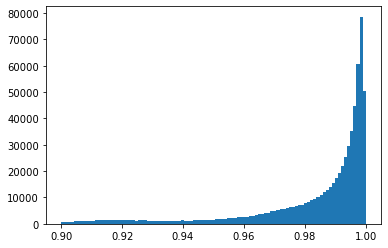

In [13]:
plt.hist(PL.abund_dic['He1r_6678A']/ (PL.abund_dic['He1r_6678A']+PL.abund_dic['He2r_4686A']), bins=np.linspace(0.9, 1., 100));

<ipython-input-14-f4582881e715>:1: RuntimeWarning: divide by zero encountered in log10
  plt.hist(12 + np.log10(PL.abund_dic['He1r_6678A']+PL.abund_dic['He2r_4686A']), bins=np.linspace(11, 11.5, 100));
<ipython-input-14-f4582881e715>:1: RuntimeWarning: invalid value encountered in log10
  plt.hist(12 + np.log10(PL.abund_dic['He1r_6678A']+PL.abund_dic['He2r_4686A']), bins=np.linspace(11, 11.5, 100));


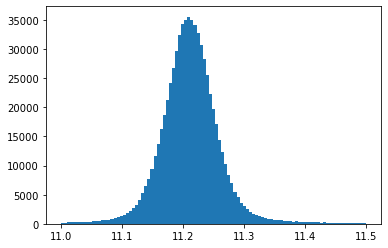

In [14]:
plt.hist(12 + np.log10(PL.abund_dic['He1r_6678A']+PL.abund_dic['He2r_4686A']), bins=np.linspace(11, 11.5, 100));

# Start Plotting

/Users/christophemorisset/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-15-84cac4d838b6>:4: RuntimeWarning: invalid value encountered in true_divide
  image = PL.get_image(PL.obs.extinction.cHbeta, type_='orig') / PL.get_image(PL.obs.extinction.cHbeta, type_='median')


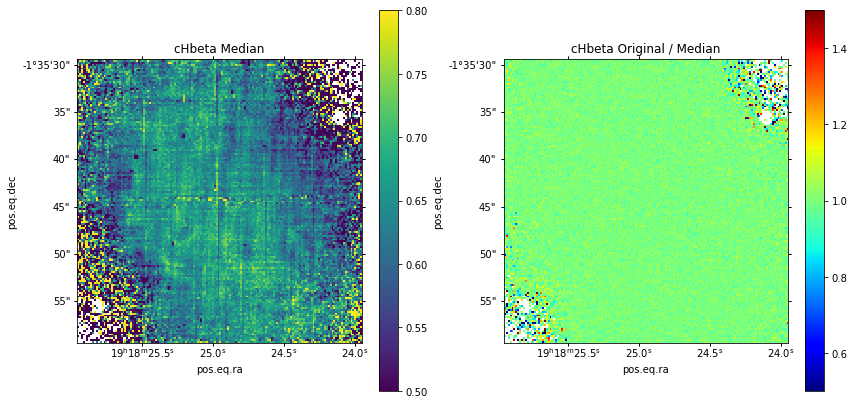

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), subplot_kw={'projection': PL.obs.wcs})
PL.plot(ax=ax1, image=PL.get_image(PL.obs.extinction.cHbeta, type_='median'), vmin=0.5, vmax=.8, title='cHbeta Median',
            label_cut=('H1r_6563A', 'H1r_4861A'), SN_cut=2.5)
image = PL.get_image(PL.obs.extinction.cHbeta, type_='orig') / PL.get_image(PL.obs.extinction.cHbeta, type_='median')
PL.plot(ax=ax2, image=image, vmin=0.5, vmax=1.5, cmap='jet', title='cHbeta Original / Median',
            label_cut=('H1r_6563A', 'H1r_4861A'), SN_cut=2.5)

In [16]:
errors = PL.obs.getError()
intenses = PL.obs.getIntens()
for line in PL.obs.getSortedLines():
    error = PL.obs.reshape(errors[line.label])[:,:,0]
    intens = PL.obs.reshape(intenses[line.label])[:,:,0]
    mask = np.isfinite(error) & (intens > 0.1)
    print('{:15s} {:9.3f}  {:9.3f} '.format(line.label, np.nanmedian(intens[mask]), np.nanmedian(error[mask])))

Ar3_7136A        3601.498      0.053 
Ar3_7751A         847.443      0.092 
Ar4_4711A         280.921      0.560 
Ar4_4740A         307.916      0.375 
Ar5_7005A          43.950      0.711 
C1_8728A           55.000      0.484 
C2r_5342.0A       109.765      0.566 
C2r_6462.0A        86.101      0.468 
Cl3_5518A         229.314      0.283 
Cl3_5538A         203.771      0.310 
Cl4_7531A          75.226      0.454 
Cl4_8046A          90.032      0.377 
H1r_4861A       22099.354      0.052 
H1r_6563A       63426.211      0.050 
H1r_8100.0         33.629      0.315 
H1r_8400.0         21.214      0.460 
H1r_8750A         266.153      0.176 
H1r_9229A         597.658      0.104 
He1r_4713A        333.646      0.488 
He1r_5876A       5387.551      0.055 
He1r_6678A       1524.230      0.064 
He1r_7065A        788.602      0.082 
He1r_7281A        229.625      0.225 
He2r_4686A        381.150      0.343 
N1_5200A          803.139      0.164 
N2_5755A          488.696      0.144 
N2_6548A    

/Users/christophemorisset/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


0.6345323168270907


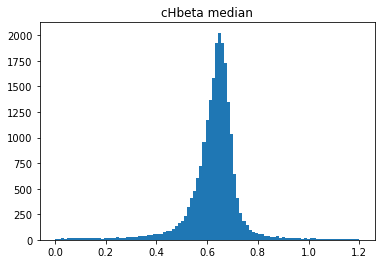

In [17]:
f, ax = plt.subplots()
ax.hist(PL.get_image(PL.obs.extinction.cHbeta, type_='median').ravel(), bins=np.linspace(0, 1.2, 100))
ax.set_title('cHbeta median')
print(np.nanmedian(PL.obs.extinction.cHbeta));

/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:278: RuntimeWarning: invalid value encountered in log10
  this_image = np.log10(this_image)
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:209: RuntimeWarning: divide by zero encountered in true_divide
  return self.get_image(label=label[0], type_=type_) / self.get_image(label=label[1], type_=type_)
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:209: RuntimeWarning: invalid value encountered in true_divide
  return self.get_image(label=label[0], type_=type_) / self.get_image(label=label[1], type_=type_)


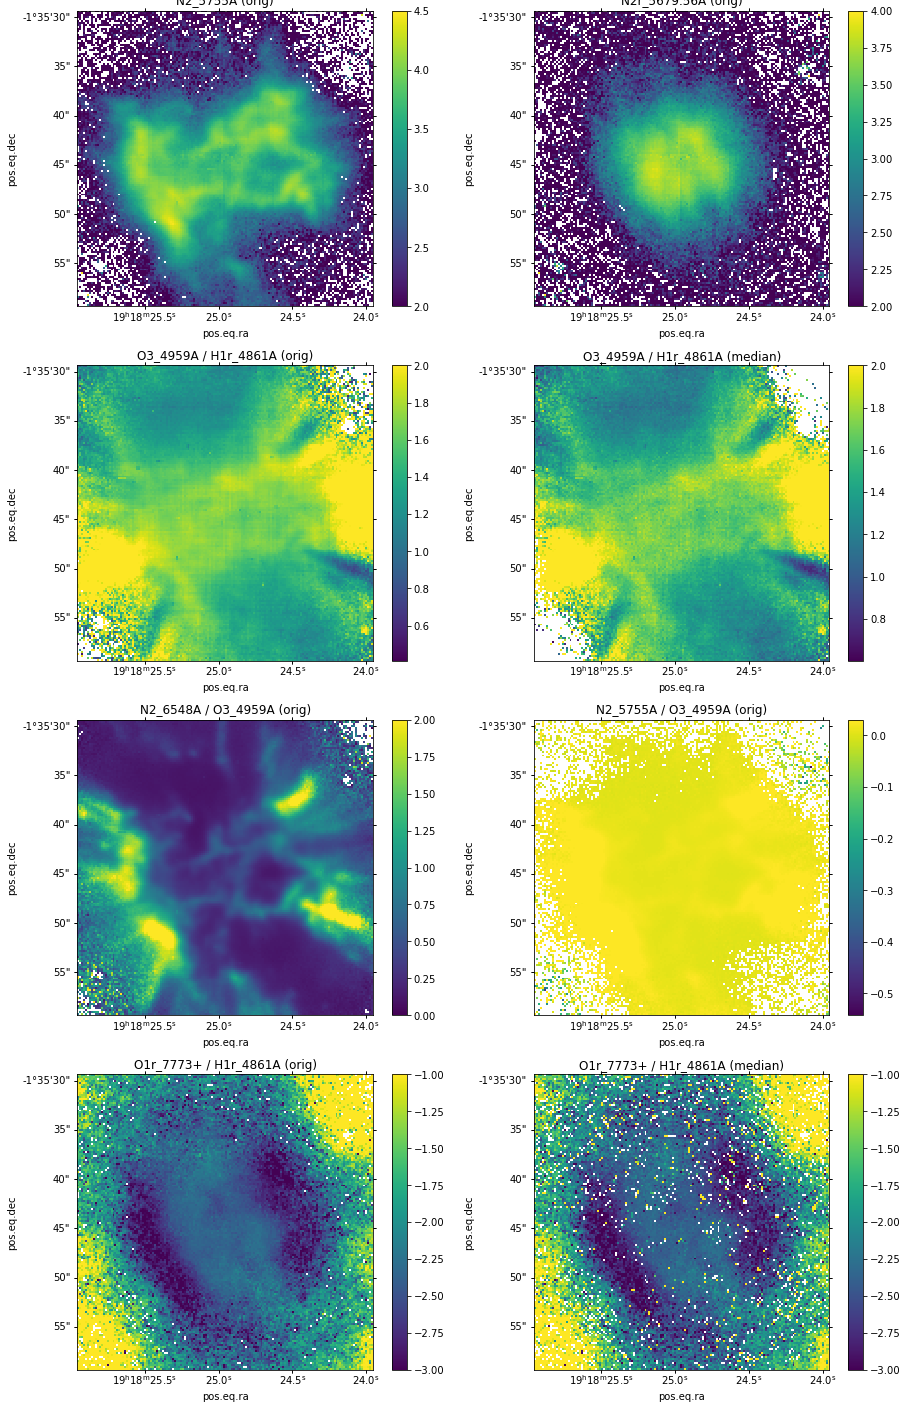

In [18]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(15, 25), subplot_kw={'projection': PL.obs.wcs})
PL.plot(ax=ax1, label='N2_5755A', type_='orig', use_log=True, vmin=2, vmax=4.5, SN_cut=None)
PL.plot(ax=ax2, label='N2r_5679.56A', type_='orig', use_log=True, vmin=2, vmax=4., SN_cut=None)
PL.plot(ax=ax3, label=('O3_4959A', 'H1r_4861A'), type_='orig', vmax=2, SN_cut=(2.5, 2.5))
PL.plot(ax=ax4, label=('O3_4959A', 'H1r_4861A'), type_='median', vmax=2, SN_cut=(4.5, 4.5))
PL.plot(ax=ax5, label=('N2_6548A', 'O3_4959A'), type_='orig', vmax=2, SN_cut=(2.5, 2.5))
PL.plot(ax=ax6, label=('N2_5755A', 'O3_4959A'), type_='orig', vmax=.03, SN_cut=(2.5, 2.5))
PL.plot(ax=ax7, label=('O1r_7773+', 'H1r_4861A'), type_='orig', use_log=True, vmin=-3, vmax=-1,  SN_cut=None)
PL.plot(ax=ax8, label=('O1r_7773+', 'H1r_4861A'), type_='median', use_log=True, vmin=-3, vmax=-1,  SN_cut=None)

/Users/christophemorisset/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


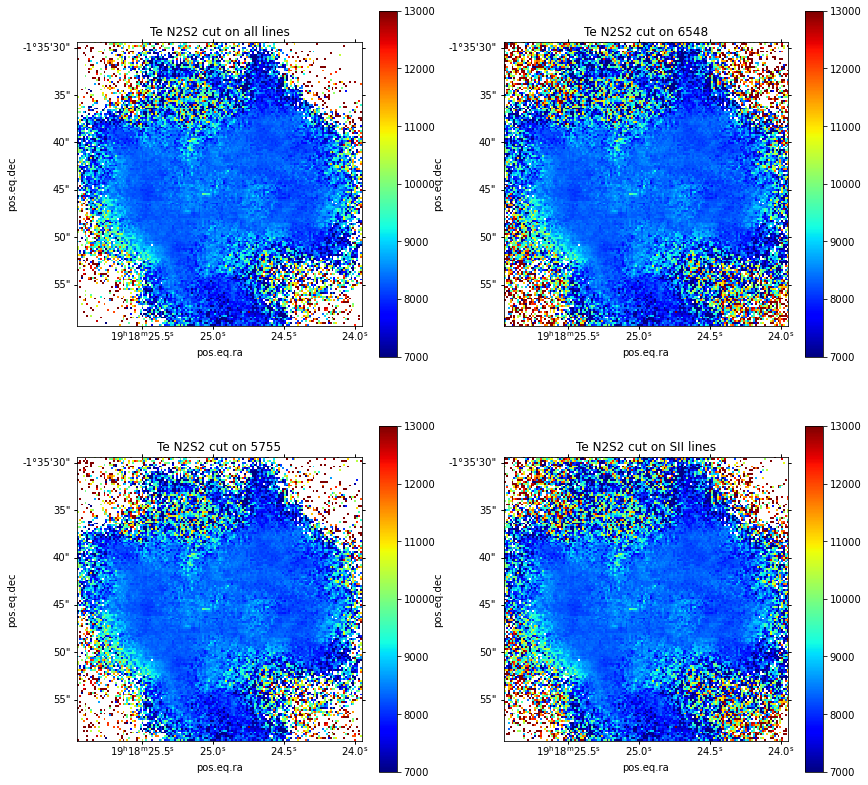

In [19]:
SN_cut = 2
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, subplot_kw={'projection': PL.obs.wcs}, figsize=(14,14))
PL.plot(ax=ax1, data=PL.TeNe['N2S2']['Te'], title='Te N2S2 cut on all lines', vmin=7000, vmax=13000, cmap='jet', 
        label_cut=('N2_6548A', 'N2_5755A', 'S2_6716A', 'S2_6731A'), SN_cut=SN_cut)
PL.plot(ax=ax2, data=PL.TeNe['N2S2']['Te'], title='Te N2S2 cut on 6548', vmin=7000, vmax=13000, cmap='jet', 
        label_cut=('N2_6548A'), SN_cut=SN_cut)
PL.plot(ax=ax3, data=PL.TeNe['N2S2']['Te'], title='Te N2S2 cut on 5755', vmin=7000, vmax=13000, cmap='jet', 
        label_cut=('N2_5755A'), SN_cut=SN_cut)
PL.plot(ax=ax4, data=PL.TeNe['N2S2']['Te'], title='Te N2S2 cut on SII lines', vmin=7000, vmax=13000, cmap='jet', 
        label_cut=('S2_6716A', 'S2_6731A'), SN_cut=SN_cut)

/Users/christophemorisset/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


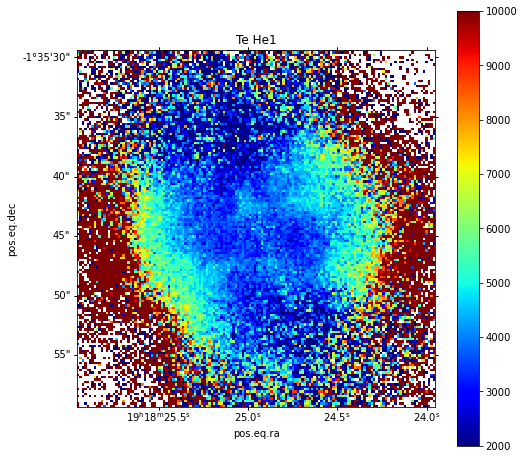

In [20]:
f, ax = plt.subplots(subplot_kw={'projection': PL.obs.wcs}, figsize=(8,8))
PL.plot(data=PL.TeNe['He1']['Te'], vmin=2000, vmax=10000, title='Te He1', ax=ax, cmap='jet')

/Users/christophemorisset/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


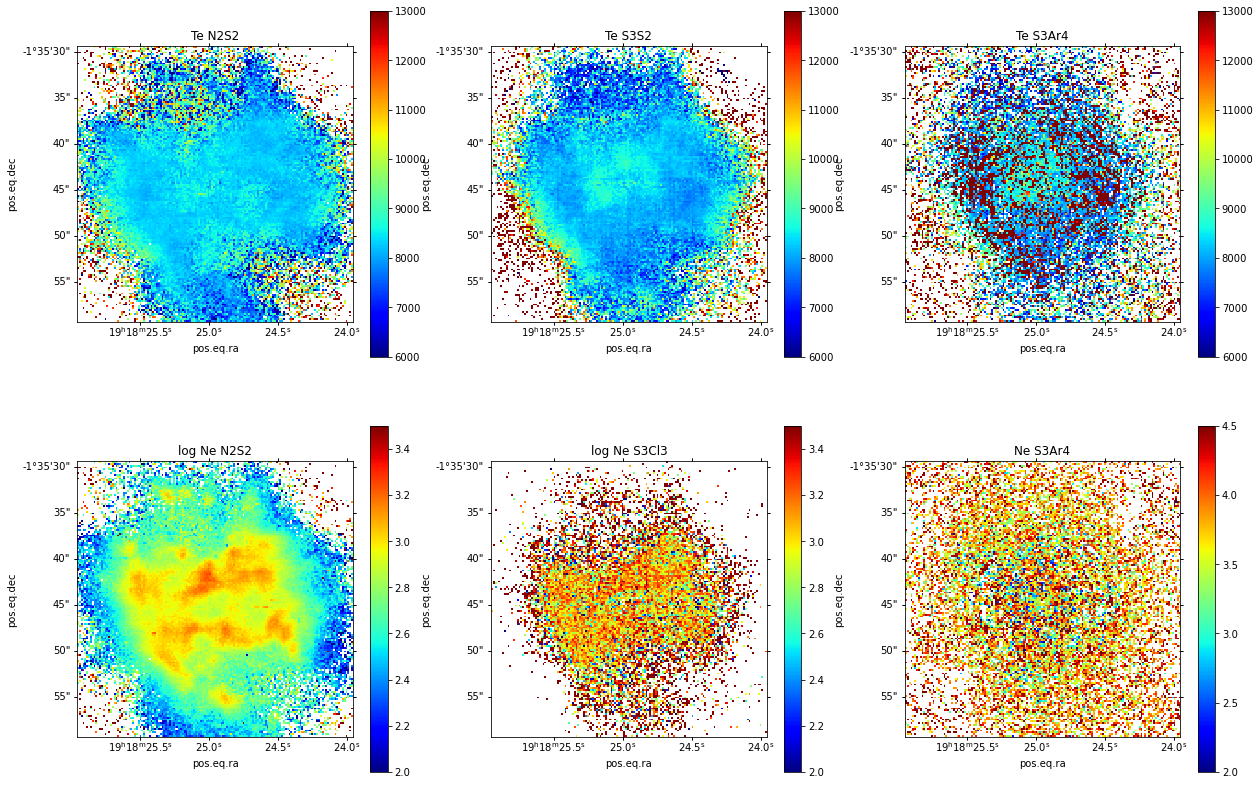

In [21]:
SN_cut = 2
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, subplot_kw={'projection': PL.obs.wcs}, figsize=(21,14))
PL.plot(ax=ax1, data=PL.TeNe['N2S2']['Te'], title='Te N2S2', vmin=6000, vmax=13000, cmap='jet', 
        label_cut=('N2_6548A', 'N2_5755A', 'S2_6716A', 'S2_6731A'), SN_cut=SN_cut)
PL.plot(ax=ax2, data=PL.TeNe['S3S2']['Te'], title='Te S3S2', vmin=6000, vmax=13000, cmap='jet', 
        label_cut=('S3_9069A', 'S3_6312A', 'S2_6716A', 'S2_6731A'), SN_cut=SN_cut)
PL.plot(ax=ax3, data=PL.TeNe['S3Ar4']['Te'], title='Te S3Ar4', vmin=6000, vmax=13000, cmap='jet', 
        label_cut=('S3_9069A', 'S3_6312A', 'Ar4_4711A', 'Ar4_4740A'), SN_cut=None)
PL.plot(ax=ax4, data=np.log10(PL.TeNe['N2S2']['Ne']), title='log Ne N2S2', vmin=2, vmax=3.5, cmap='jet', 
        label_cut=('N2_6548A', 'N2_5755A', 'S2_6716A', 'S2_6731A'), SN_cut=SN_cut)
PL.plot(ax=ax5, data=np.log10(PL.TeNe['S3Cl3']['Ne']), title='log Ne S3Cl3', vmin=2, vmax=3.5, cmap='jet', 
        label_cut=('S3_9069A', 'S3_6312A', 'Cl3_5518A', 'Cl3_5538A'), SN_cut=SN_cut, type_='orig')
PL.plot(ax=ax6, data=np.log10(PL.TeNe['S3Ar4']['Ne']), title='Ne S3Ar4', vmin=2, vmax=4.5, cmap='jet', 
        label_cut=('S3_9069A', 'S3_6312A', 'Ar4_4711A', 'Ar4_4740A'), SN_cut=None, type_='median')
f.savefig(PL.PDF_name+'_TeNe.pdf')

/Users/christophemorisset/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/christophemorisset/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


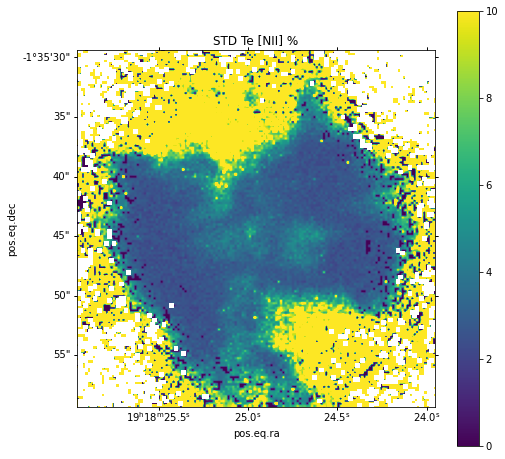

In [22]:
PL.plot_STD(data=PL.TeNe['N2S2']['Te'], vmin=0, vmax=10, title='STD Te [NII] %')

In [23]:
intenses = PL.obs.getIntens()
for line in PL.obs.getSortedLines():
    intens = PL.obs.reshape(intenses[line.label])[:,:,0]
    try:
        abund = 12+np.log10(PL.obs.reshape(PL.abund_dic[line.label])[:,:,0])
        mask = np.isfinite(intens)
        mask2 = np.isfinite(abund)
        print('{:15s} {:9.2e} {:9.2f} {:9.2f}'.format(line.label, 
                                              intens[mask].sum(), 
                                              np.median(abund[mask2]), 
                                              np.nanstd(abund[mask2])))
    except:
        print('{:15s} NO ABUNDANCES'.format(line.label))
        

<ipython-input-23-4f9aa963c0c9>:5: RuntimeWarning: divide by zero encountered in log10
  abund = 12+np.log10(PL.obs.reshape(PL.abund_dic[line.label])[:,:,0])


Ar3_7136A        3.10e+08      6.36      0.27
Ar3_7751A        7.06e+07      6.30      0.55
Ar4_4711A        2.35e+07      5.67      1.82
Ar4_4740A        1.58e+07      5.75      1.60
Ar5_7005A        9.64e+05      4.54      1.80
C1_8728A         1.47e+06      6.13      1.47
C2r_5342.0A      3.93e+06      9.58      1.78
C2r_6462.0A      3.74e+06      9.34      1.43
Cl3_5518A        1.39e+07      5.19      0.97
Cl3_5538A        1.16e+07      5.21      1.14
Cl4_7531A        2.82e+06      4.86      1.36
Cl4_8046A        4.89e+06      4.51      1.20
H1r_4861A        1.89e+09     12.00      0.00
H1r_6563A        5.38e+09     11.99      0.01
H1r_8100.0      NO ABUNDANCES
H1r_8400.0      NO ABUNDANCES
H1r_8750A        1.92e+07     11.97      0.76
H1r_9229A        4.36e+07     11.95      0.53
He1r_4713A       1.88e+07     11.33      1.79
He1r_5876A       4.44e+08     11.21      0.23
He1r_6678A       1.23e+08     11.20      0.18
He1r_7065A       7.18e+07     11.16      0.21
He1r_7281A       1.5

<ipython-input-23-4f9aa963c0c9>:5: RuntimeWarning: invalid value encountered in log10
  abund = 12+np.log10(PL.obs.reshape(PL.abund_dic[line.label])[:,:,0])


<ipython-input-26-0e7f9581ee64>:6: RuntimeWarning: divide by zero encountered in log10
  to_show = 12+np.log10(PL.abund_dic[line.label])
<ipython-input-26-0e7f9581ee64>:6: RuntimeWarning: invalid value encountered in log10
  to_show = 12+np.log10(PL.abund_dic[line.label])


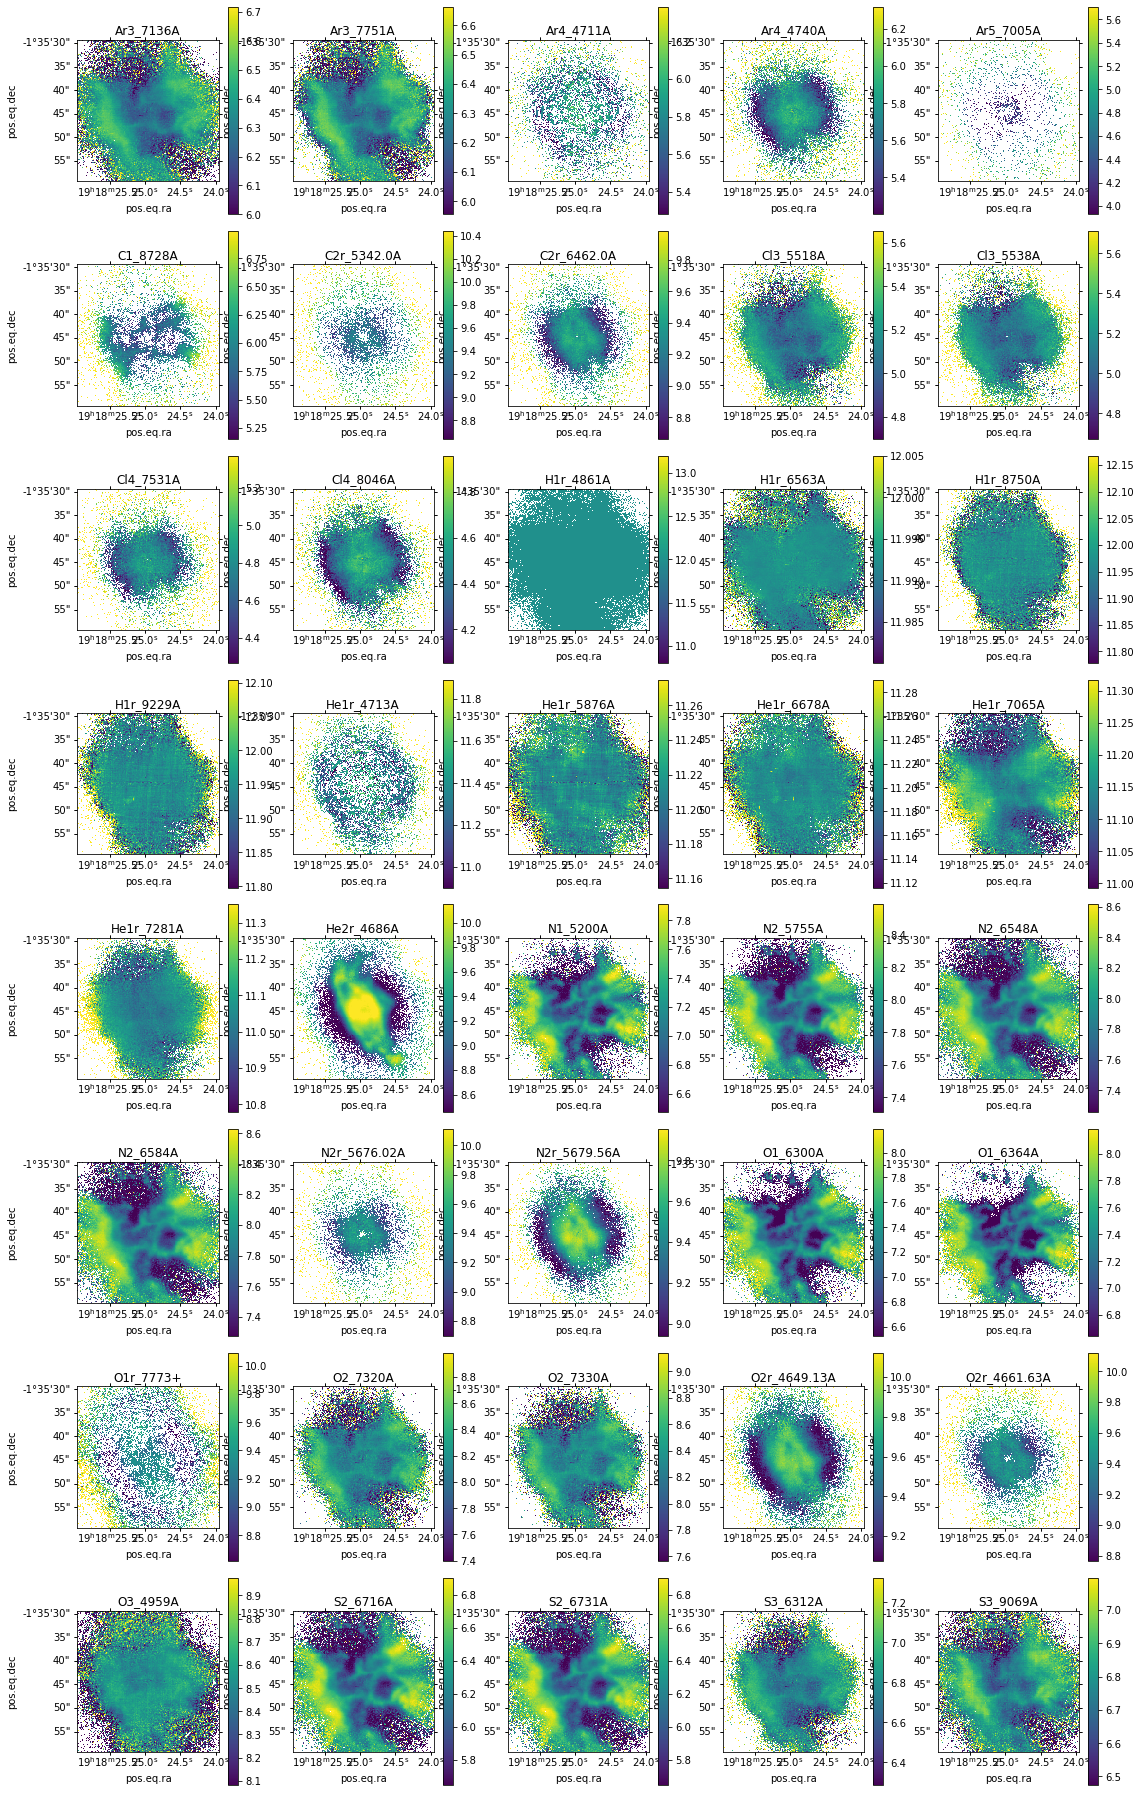

In [26]:
f, axes = plt.subplots(8,5,figsize=(15,25), subplot_kw={'projection': PL.obs.wcs})
i_axes = 0
for line in PL.obs.getSortedLines()[0:42]:
    if line.is_valid:
        mask = PL.get_mask_SN(line.label, 2.5)
        to_show = 12+np.log10(PL.abund_dic[line.label])
        to_show[np.isinf(to_show)] = np.nan
        med = np.nanmedian(PL.get_image(to_show, type_='orig')[~mask])
        to_show[to_show < (med - 6)] = np.nan
        med = np.nanmedian(PL.get_image(to_show, type_='orig')[~mask])
        std = np.nanstd(PL.get_image(to_show, type_='orig')[~mask])
        vmin = med - 1.5 * std
        vmax = med + 1.5 * std
        #print(line.label, max_to_show, med, std, vmin, vmax, mask.sum())
        PL.plot(data=to_show, title=line.label, ax=axes.ravel()[i_axes], vmin=vmin, vmax=vmax, type_='orig', mask=mask)
        i_axes += 1
f.tight_layout()
f.savefig(PL.PDF_name+'_abunds.pdf')

<ipython-input-27-07891a196107>:6: RuntimeWarning: divide by zero encountered in log10
  to_show = 12+np.log10(PL.abund_dic[line.label])
<ipython-input-27-07891a196107>:6: RuntimeWarning: invalid value encountered in log10
  to_show = 12+np.log10(PL.abund_dic[line.label])
/Users/christophemorisset/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


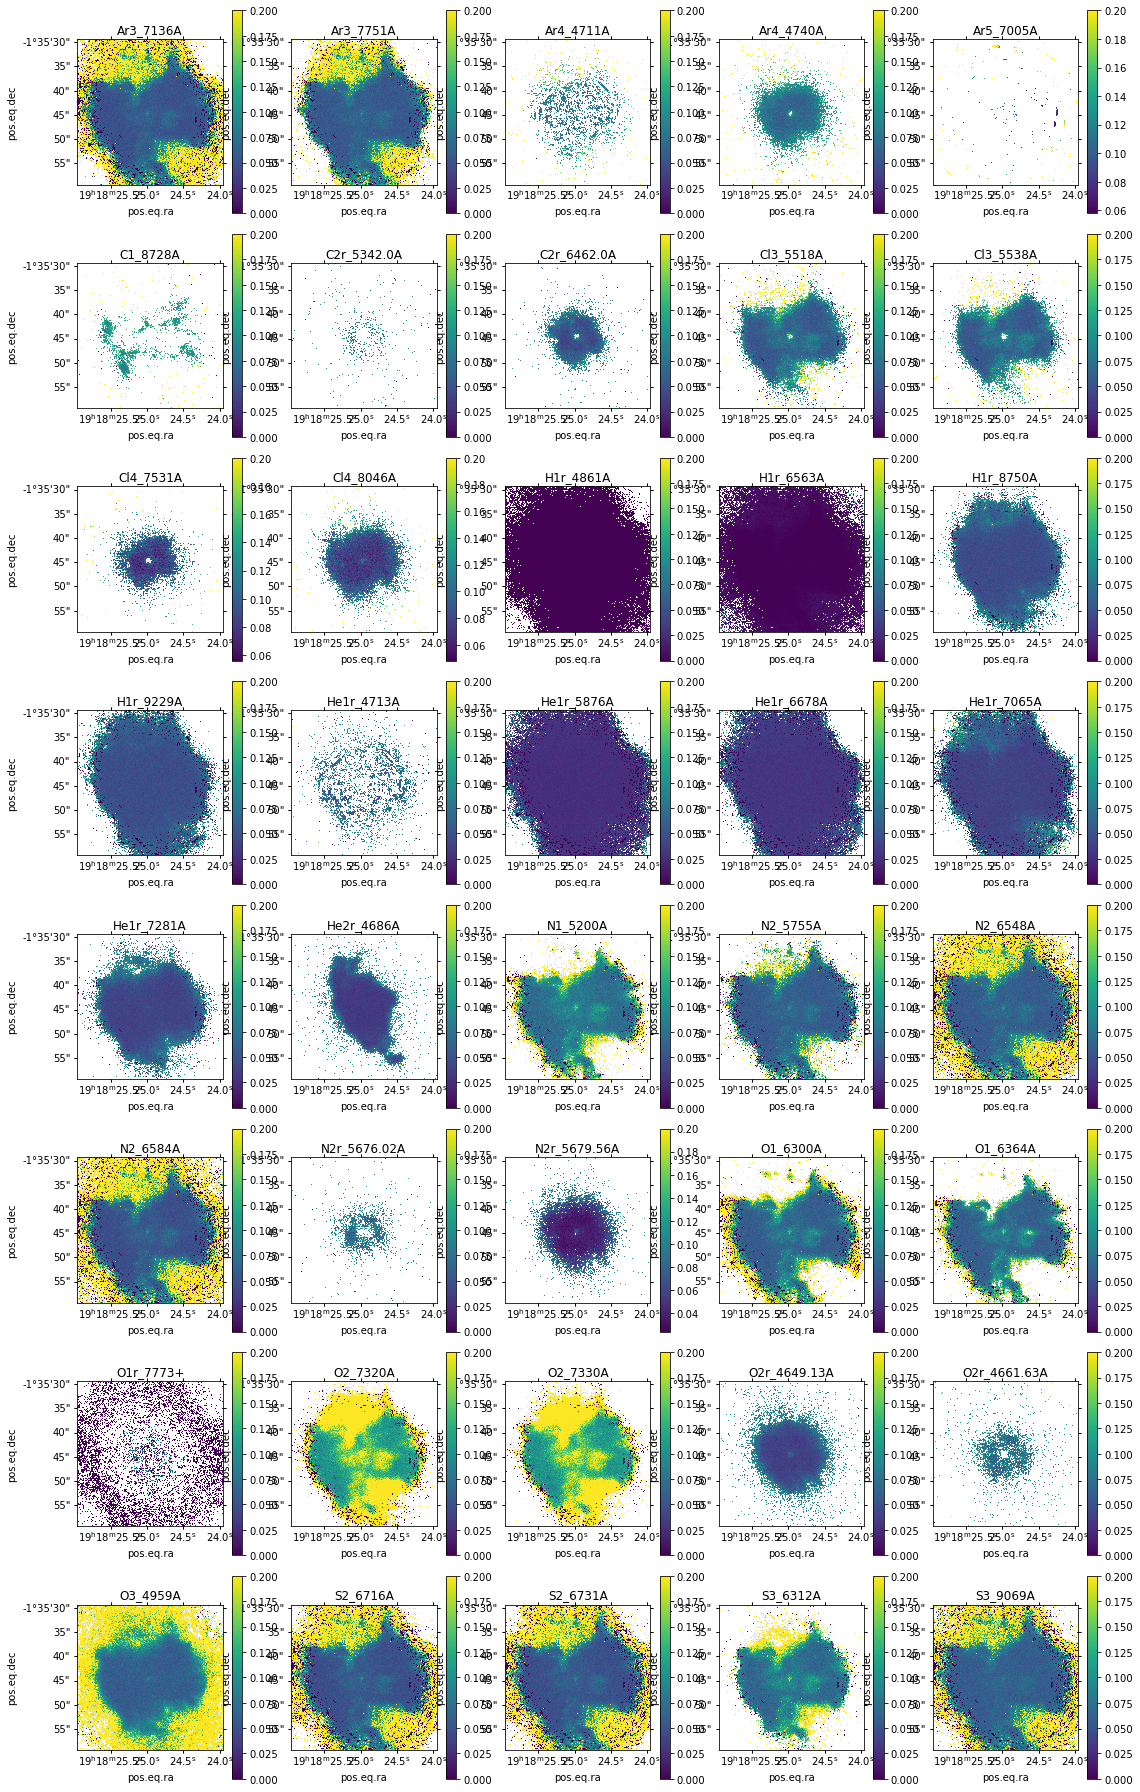

In [27]:
f, axes = plt.subplots(8,5,figsize=(15,25), subplot_kw={'projection': PL.obs.wcs})
i_axes = 0
for line in PL.obs.getSortedLines()[0:42]:
    if line.is_valid:
        mask = PL.get_mask_SN(line.label, 4.5)
        to_show = 12+np.log10(PL.abund_dic[line.label])
        to_show[np.isinf(to_show)] = np.nan
        med = np.nanmedian(PL.get_image(to_show, type_='orig')[~mask])
        to_show[to_show < (med - 6)] = np.nan
        to_show
        med = np.nanmedian(PL.get_image(to_show, type_='orig')[~mask])
        std = np.nanstd(PL.get_image(to_show, type_='orig')[~mask])
        vmin = med - 1.5 * std
        vmax = med + 1.5 * std
        #print(line.label, max_to_show, med, std, vmin, vmax, mask.sum())
        PL.plot(data=to_show, title=line.label, ax=axes.ravel()[i_axes], type_='std', mask=mask, vmax=0.2)
        i_axes += 1
f.tight_layout()
f.savefig(PL.PDF_name+'_abunds_uncert.pdf')

<ipython-input-34-04850d9ec9cc>:2: RuntimeWarning: divide by zero encountered in log10
  PL.plot(data=12+np.log10(PL.abund_dic['He']), title='He/H', vmin=11.15, vmax=11.25, type_='orig')
<ipython-input-34-04850d9ec9cc>:2: RuntimeWarning: invalid value encountered in log10
  PL.plot(data=12+np.log10(PL.abund_dic['He']), title='He/H', vmin=11.15, vmax=11.25, type_='orig')


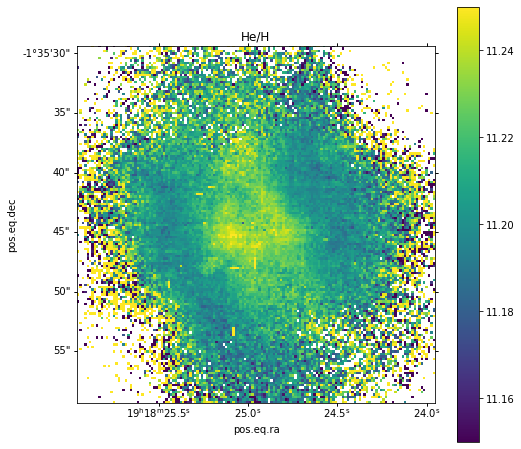

In [34]:
PL.abund_dic['He'] = PL.abund_dic['He1r_6678A'] + PL.abund_dic['He2r_4686A']
PL.plot(data=12+np.log10(PL.abund_dic['He']), title='He/H', vmin=11.15, vmax=11.25, type_='orig')

<ipython-input-35-7ae16b0916a2>:3: RuntimeWarning: divide by zero encountered in true_divide
  ADF_Op = np.log10(PL.abund_dic['O1r_7773+'] / (PL.abund_dic['O2_7330A']+PL.abund_dic['O2_7330A']) * 2)
<ipython-input-35-7ae16b0916a2>:3: RuntimeWarning: invalid value encountered in true_divide
  ADF_Op = np.log10(PL.abund_dic['O1r_7773+'] / (PL.abund_dic['O2_7330A']+PL.abund_dic['O2_7330A']) * 2)
<ipython-input-35-7ae16b0916a2>:3: RuntimeWarning: divide by zero encountered in log10
  ADF_Op = np.log10(PL.abund_dic['O1r_7773+'] / (PL.abund_dic['O2_7330A']+PL.abund_dic['O2_7330A']) * 2)
<ipython-input-35-7ae16b0916a2>:3: RuntimeWarning: invalid value encountered in log10
  ADF_Op = np.log10(PL.abund_dic['O1r_7773+'] / (PL.abund_dic['O2_7330A']+PL.abund_dic['O2_7330A']) * 2)
<ipython-input-35-7ae16b0916a2>:4: RuntimeWarning: divide by zero encountered in log10
  ADF_Opp = np.log10(PL.abund_dic['O2r_4649.13A'] / PL.abund_dic['O3_4959A'])
<ipython-input-35-7ae16b0916a2>:4: RuntimeWarning: invali

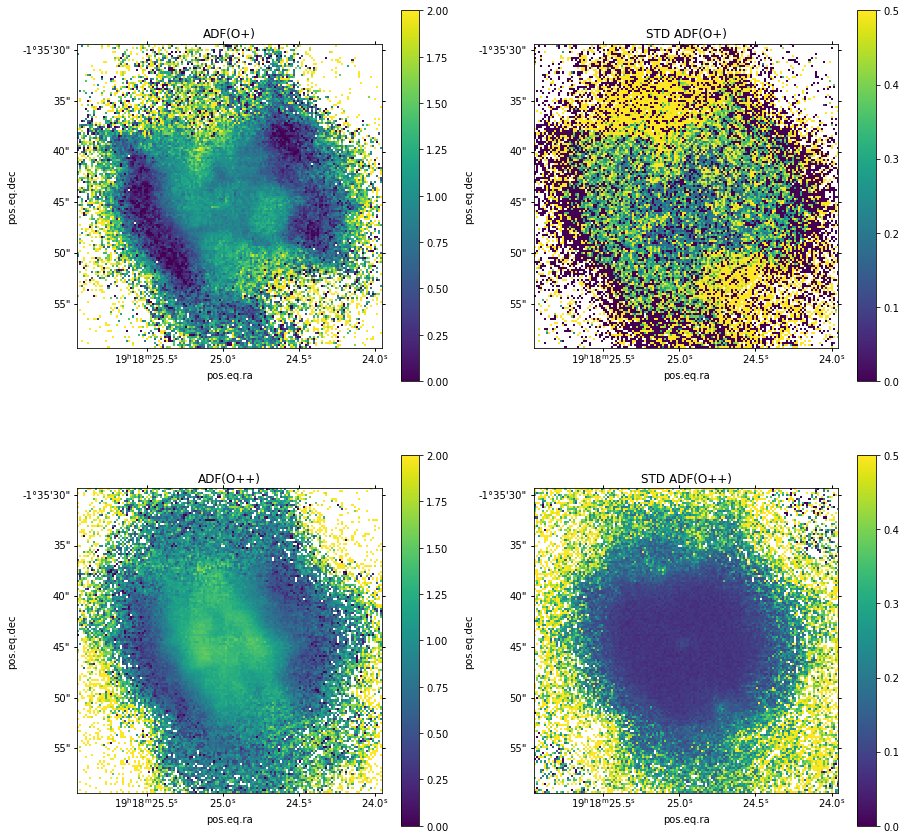

In [35]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,15), subplot_kw={'projection': PL.obs.wcs})

ADF_Op = np.log10(PL.abund_dic['O1r_7773+'] / (PL.abund_dic['O2_7330A']+PL.abund_dic['O2_7330A']) * 2)
ADF_Opp = np.log10(PL.abund_dic['O2r_4649.13A'] / PL.abund_dic['O3_4959A'])

PL.plot(data=ADF_Op, title='ADF(O+)', ax=ax1, vmin=0, vmax=2, type_='orig')
PL.plot(data=ADF_Op, title='STD ADF(O+)', ax=ax2, vmin=0, vmax=.5, type_='std')
PL.plot(data=ADF_Opp, title='ADF(O++)', ax=ax3, vmin=0, vmax=2, type_='orig')
PL.plot(data=ADF_Opp, title='STD ADF(O++)', ax=ax4, vmin=0, vmax=.5, type_='std')

/Users/christophemorisset/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


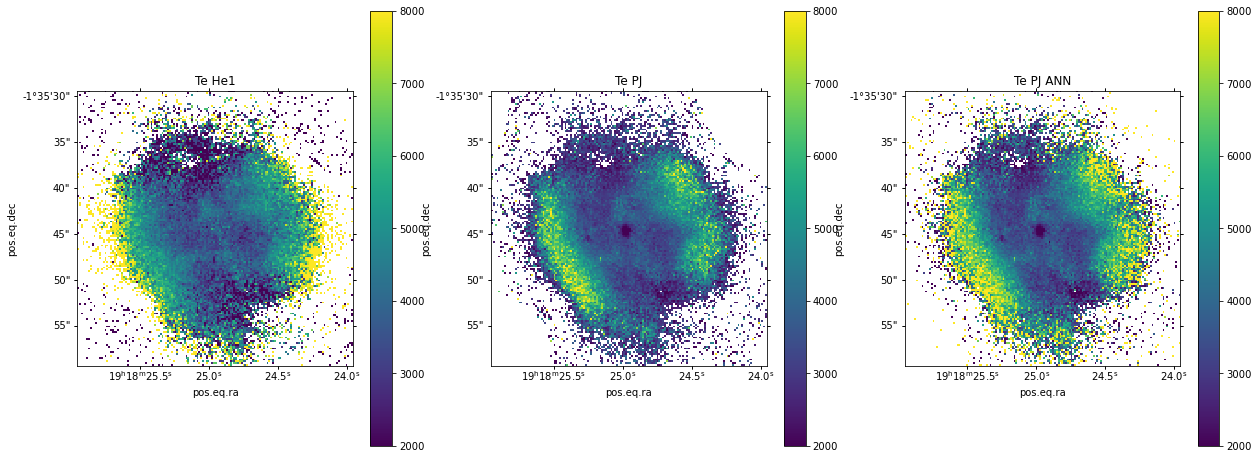

In [36]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={'projection': PL.obs.wcs}, figsize=(21,8))
PL.plot(data=PL.TeNe['He1']['Te'], vmin=2000, vmax=8000, title='Te He1', ax=ax1, SN_cut=4, label_cut='He1r_7281A')
PL.plot(data=PL.TeNe['PJ']['Te'], vmin=2000, vmax=8000,  title='Te PJ', ax=ax2, SN_cut=4, label_cut='He1r_7281A')
PL.plot(data=PL.TeNe['PJ_ANN']['Te'], vmin=2000, vmax=8000,  title='Te PJ ANN', ax=ax3, SN_cut=4, label_cut='He1r_7281A')